# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

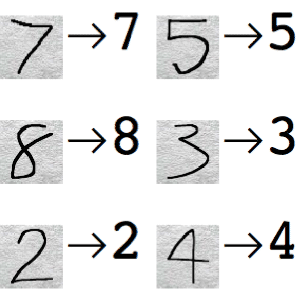

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


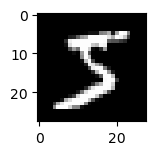

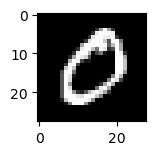

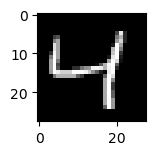

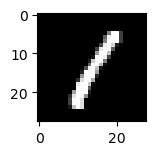

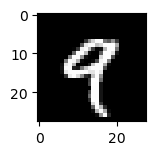

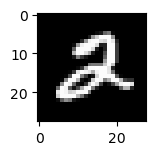

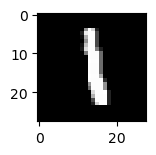

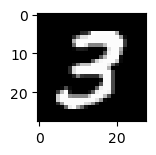

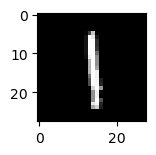

In [5]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In [1]:
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping 
from keras.layers import Resizing
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
import cv2
import math
from scipy import ndimage

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [11]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [5]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



Sử dụng cơ chế dropout để penalize các parameters học được

In [4]:
def define_model():
  #Adding dropout to penalize the parameters
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout((0.2)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout((0.2)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout((0.2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01,momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [6]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    
    # fit model
    callback = EarlyStopping(monitor='loss', patience=3)
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY),callbacks = [callback], verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [7]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [8]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [9]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)





> 98.358
> 98.125
> 98.300
> 97.992
> 98.092


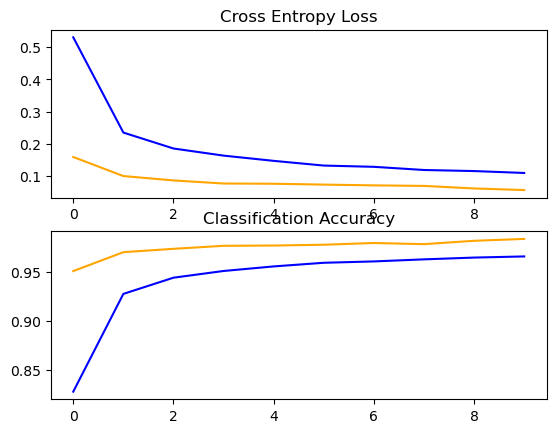

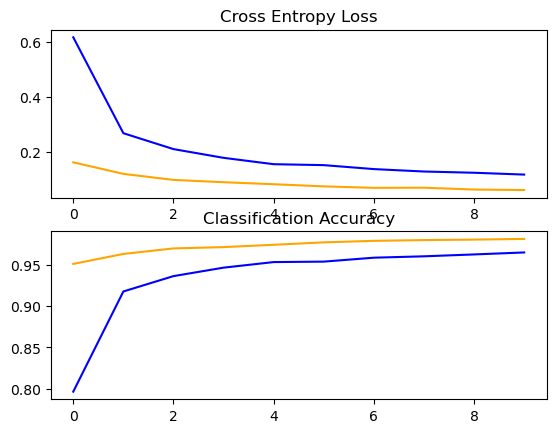

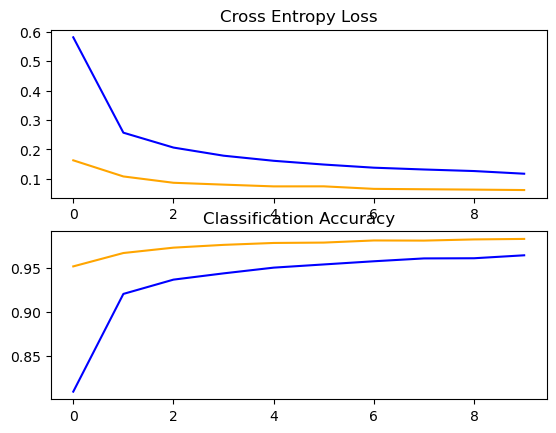

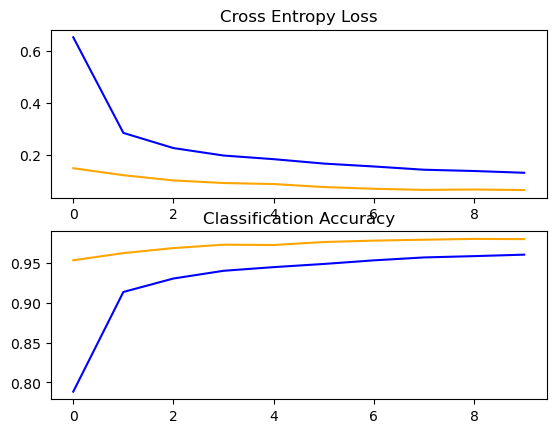

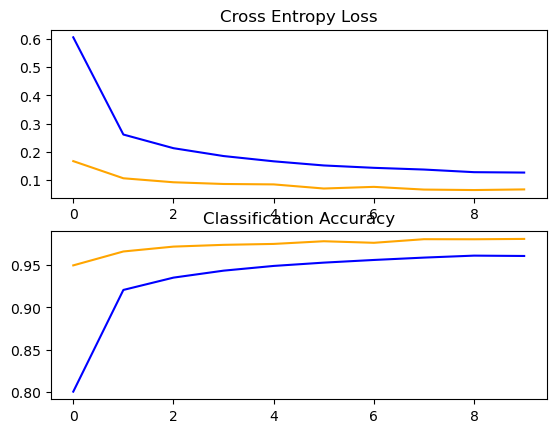

Accuracy: mean=98.173 std=0.136, n=5


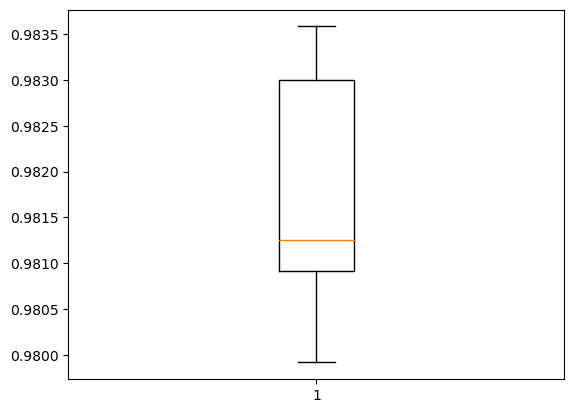

In [12]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

Thêm hàm callback để giảm thời gian huấn luyện và giảm khả năng bị overfit khi mô hình đã học được các đặc trưng của mô hình.

In [108]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  callback = EarlyStopping(monitor='loss', patience=3)
    # fit model
  #callbacks to prevent overlearning.
  model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY),callbacks=[callback], verbose=0)

  # save model
  model.save('final_model.h5')

In [111]:
run_test_harness2()

c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluate Final Model

## Make Prediction

In [9]:
from PIL import Image
import numpy as np

Biến đổi ảnh thật phù hợp với tập huấn luyện với phép biến đổi affine

In [7]:
#Preprocess image to match training sample layout using affine transform.
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

def preprocessing_rl_img(image_link):	
 # create an an array where we can store our 4 pictures
	# and the correct values
	gray = cv2.imread(image_link, 0)
		# gray = cv2.imread(no, 0)

		# rescale it
	gray = cv2.resize(255-gray, (28, 28))
		# better black and white version
	(thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

	while np.sum(gray[0]) == 0:
		gray = gray[1:]

	while np.sum(gray[:,0]) == 0:
		gray = np.delete(gray,0,1)

	while np.sum(gray[-1]) == 0:
		gray = gray[:-1]

	while np.sum(gray[:,-1]) == 0:
		gray = np.delete(gray,-1,1)

	rows,cols = gray.shape

	if rows > cols:
		factor = 20.0/rows
		rows = 20
		cols = int(round(cols*factor))
			# first cols than rows
		gray = cv2.resize(gray, (cols,rows))
	else:
		factor = 20.0/cols
		cols = 20
		rows = int(round(rows*factor))
			# first cols than rows
		gray = cv2.resize(gray, (cols, rows))

	colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
	rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
	gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')

	
     
	shiftx,shifty = getBestShift(gray)
	shifted = shift(gray,shiftx,shifty)
	gray = shifted

		# save the processed images
	#cv2.imwrite("img_preprocessing_.png", gray)
	
	gray = gray.reshape(1, 28, 28, 1)
	flatten = gray / 255.0
	
	return flatten

Đánh giá mô hình

In [8]:
# load an image and predict the class
def run_example(filename):
  # load the image
  img = preprocessing_rl_img(filename)
  # load model
  model = load_model('final_model.h5')

  # predict the class
  predict_value = model.predict(img)
  digit = argmax(predict_value)
  return digit



In [9]:
import os

directory = "data/21520282"
lst_directory_path = os.listdir(directory)
lst_file_path =  [os.listdir(directory + "/" + lst_directory_path[i]) for i in range(len(lst_directory_path))]
file_link_path = []
labels = []
for i in range(0,len(lst_directory_path)):
    parent_path = directory + "/" + lst_directory_path[i]
    for items in lst_file_path[i]:
        link = parent_path + "/" + items
        file_link_path.append(link)
        labels.append(i)

In [10]:
i = 0
correct = 0
for digit in file_link_path:
# entry point, run the example
    pred_label = run_example(digit)
    if pred_label == labels[i]: 
        correct += 1
    i += 1

C:\Users\DELL\AppData\Local\Temp\ipykernel_21076\3190513052.py:3: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  cy,cx = ndimage.measurements.center_of_mass(img)




1/1 [==============================] - 0s 83ms/step


In [11]:
accuracy = (correct / i)* 100
print("Accuracy on 21520282 digits: ",accuracy)

Accuracy on 21520282 digits:  90.0


In [12]:
directory = "data/21521869"
lst_directory_path = os.listdir(directory)
lst_file_path =  [os.listdir(directory + "/" + lst_directory_path[i]) for i in range(len(lst_directory_path))]
file_link_path = []
labels = []
for i in range(0,len(lst_directory_path)):
    parent_path = directory + "/" + lst_directory_path[i]
    for items in lst_file_path[i]:
        link = parent_path + "/" + items
        file_link_path.append(link)
        labels.append(i)

In [15]:
i = 0
correct = 0
for digit in file_link_path:
# entry point, run the example
    pred_label = run_example(digit)
    if pred_label == labels[i]: 
        correct += 1
    i += 1

C:\Users\DELL\AppData\Local\Temp\ipykernel_25452\465541219.py:2: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  cy,cx = ndimage.measurements.center_of_mass(img)


1/1 [==============================] - 0s 77ms/step


In [16]:
accuracy = (correct / i)* 100
print("Accuracy on 21521869 digits: ",accuracy)

Accuracy on 21521869 digits:  76.66666666666667


In [13]:
directory = "data/21520569"
lst_directory_path = os.listdir(directory)
lst_file_path =  [os.listdir(directory + "/" + lst_directory_path[i]) for i in range(len(lst_directory_path))]
file_link_path = []
labels = []
for i in range(0,len(lst_directory_path)):
    parent_path = directory + "/" + lst_directory_path[i]
    for items in lst_file_path[i]:
        link = parent_path + "/" + items
        file_link_path.append(link)
        labels.append(i)

In [18]:
i = 0
correct = 0
for digit in file_link_path:
# entry point, run the example
    pred_label = run_example(digit)
    if pred_label == labels[i]: 
        correct += 1
    i += 1

C:\Users\DELL\AppData\Local\Temp\ipykernel_25452\465541219.py:2: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  cy,cx = ndimage.measurements.center_of_mass(img)


1/1 [==============================] - 0s 74ms/step


In [19]:
accuracy = (correct / i)* 100
print("Accuracy on 21520569 digits: ",accuracy)

Accuracy on 21520569 digits:  73.33333333333333
